## 02 qPCR score

This notebook illustrates how the qPCR score was calculated and statistical test shown in [Figure 2D](assets/Figure_2D.tif)
***

### 2.1 Clean environment. Load libraries.

In [8]:
rm(list = ls())

##-- load libs
suppressMessages(library(ggplot2))
suppressMessages(library(reshape2))
suppressMessages(library(broom))

### 2.2 Import data files.

In [9]:
##-- global variables
##-- bugs UP in R
bug.up = c('Veillonella_parvula','Enterococcus_faecium','Collinsella_aerofaciens',
           'Bifidobacterium_adolescentis','Bifidobacterium_longum',
           'Klebsiella_pneumoniae','Parabacteroides_merdae','Lactobacillus')
##-- bugs DOWN in R (UP in NR)
bug.down = c('Roseburia_intestinalis','Ruminococcus_obeum')
bug.in = c(bug.up, bug.down)

##-- data files 
sample.file = '../data/human_16S.sampleinfo.csv'
qpcr.file = '../data/human_16S_qPCR.csv'

##-- import data 
sample = read.csv(sample.file, row.names = 1)
qpcr = read.csv(qpcr.file, row.names = 1, na.strings = c('ND','NA',''))

print(dim(qpcr))

[1] 41 11


### 2.3 Preprocess data. 41 samples carry non-zero abundance for the 10 selected bugs. 40 samples were used for score calculation after removing one sample with ND (not determined) value in at least 1 bug (P30).

In [10]:
##-- remove samples with NA or ND value in at least 1 bug
patient.ex = row.names(qpcr)[which(rowSums(is.na(qpcr))>0)]
print(patient.ex) ## P30

qpcr = qpcr[!row.names(qpcr) %in% patient.ex,]
print(dim(qpcr))

[1] "P30"
[1] 40 11


### 2.4 Calculate qPCR score using 8 beneficial (UP in R) and 2 non-beneficial bugs (UP in NR).

In [11]:
##-- convert to log scale
qpcr.norm = qpcr[,-1]
qpcr.norm = log10(qpcr.norm + 1)

##-- scale on bug column, do not center
qpcr.norm = scale(qpcr.norm, center = F, scale = T)

##-- for bugs UP in NR, flip the values!
qpcr.norm[,bug.down] = -1 * qpcr.norm[,bug.down]

##-- calculate qPCR score
qpcr.norm.score = merge(qpcr[,'Response',drop=F],
                             data.frame(score = apply(qpcr.norm, 1, sum)),
                             by = 'row.names')

row.names(qpcr.norm.score) = qpcr.norm.score[,1]
qpcr.norm.score = qpcr.norm.score[,-1]

print(qpcr.norm.score)

        Response       score
P01 NonResponder  2.52021835
P02    Responder  2.74397947
P03 NonResponder  2.21640596
P04 NonResponder  3.19969310
P05 NonResponder  2.60551880
P06 NonResponder  0.75987058
P07    Responder  1.95079163
P08 NonResponder  2.22699233
P09    Responder  7.92127291
P10 NonResponder -0.19260742
P11 NonResponder -0.86811181
P12 NonResponder  2.46366765
P14 NonResponder  1.88640107
P15 NonResponder  1.98539261
P16    Responder 13.96492955
P17 NonResponder  1.54914640
P18 NonResponder  0.79400653
P19 NonResponder  3.98170984
P20    Responder 13.00285303
P21 NonResponder  2.83408295
P22 NonResponder -0.00519403
P23    Responder  5.18711138
P24    Responder  3.57168328
P25 NonResponder  2.66638676
P26 NonResponder  5.78916759
P27    Responder  5.63402877
P28    Responder  8.89318905
P29    Responder  2.10832643
P31 NonResponder  1.09514549
P32 NonResponder  1.70492060
P33    Responder  0.97701144
P34    Responder  6.16905113
P35 NonResponder  2.29062055
P36    Respond

### 2.5 Draw the qPCR score boxplot for NR and R patients.
Note that the position of each dot may look slightly different (on the x-axis) from Figure 2D because of the `jitter`  function, which utilizes random seeds to deviate the dots horizontally by a small distance for plotting purposes.

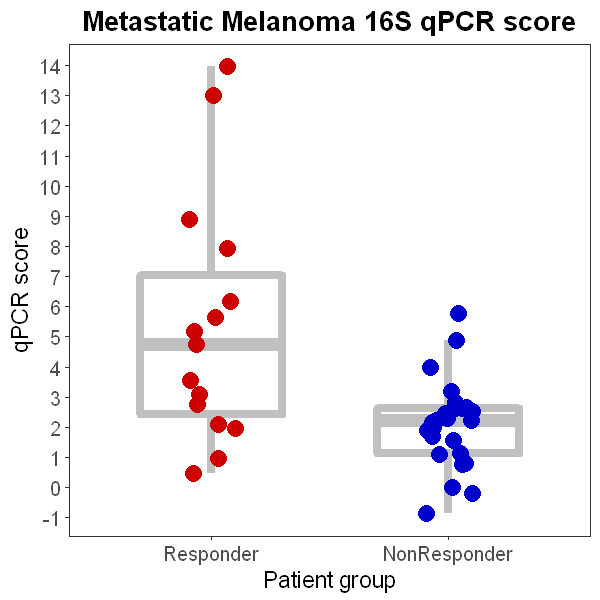

In [12]:
##-- set up R plot display options in notebook
options(jupyter.plot_mimetypes = "image/png")
options(repr.plot.width = 5, repr.plot.height = 5)

##-- draw boxplots; set up color for NR and R groups
data.plot =qpcr.norm.score
data.plot$Response = factor(data.plot$Response, levels = c('Responder',
                                                           'NonResponder'))

plot.colors = c('Responder' = '#CC0000', 'NonResponder' = '#0000CC')
plot.title = 'Metastatic Melanoma 16S qPCR score'
plot.shapes = c('Responder' = 19, 'NonResponder' = 1)
plot.y.break = 1.0

p1 = ggplot(data.plot, aes(Response, score)) +
  geom_boxplot(color = '#C0C0C0', outlier.shape = NA, width = 0.6,
               lwd=2.5, fatten = 1.5) +
  geom_jitter(aes(color = Response), width = 0.1, height = 0, size = 4.5)+
  scale_color_manual(values = plot.colors) + 
  theme_bw() +
  ggtitle(plot.title) + 
  xlab('Patient group') + 
  ylab('qPCR score') + 
  theme_bw() + 
  theme(panel.grid.major.x=element_blank(), panel.grid.major.y = element_blank(), 
        panel.grid.minor=element_blank())  +
  theme(axis.text.y=element_text(size=12), axis.title=element_text(size=14),
        plot.title=element_text(size=16,face='bold', hjust = 0.5), 
        axis.text.x=element_text(size=12), strip.text.x=element_text(size=12,face='bold'), 
        strip.background = element_rect(fill='#CCCCFF'))  +
  theme(legend.position = 'none') +
  scale_y_continuous(breaks=seq(round(min(data.plot$score)),
                                round(max(data.plot$score)),
                                plot.y.break))

print(p1)

### 2.6 Compute statistical significance of qPCR score difference between R and NR groups using Mann-Whitney-Wilcoxon Test (non-parametric).

In [13]:
##-- statistical tests
x = with(qpcr.norm.score, score[Response=='Responder'])
y = with(qpcr.norm.score, score[Response=='NonResponder'])

print(tidy(wilcox.test(x,y)))

  statistic     p.value                 method alternative
1       288 0.004275997 Wilcoxon rank sum test   two.sided


In [14]:
sessionInfo()

R version 3.4.2 (2017-09-28)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 14393)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] broom_0.4.2    reshape2_1.4.2 ggplot2_2.2.1 

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.13     compiler_3.4.2   plyr_1.8.4       bindr_0.1       
 [5] tools_3.4.2      digest_0.6.12    uuid_0.1-2       jsonlite_1.5    
 [9] evaluate_0.10.1  tibble_1.3.4     gtable_0.2.0     nlme_3.1-131    
[13] lattice_0.20-35  pkgconfig_2.0.1  rlang_0.1.4      psych_1.7.8     
[17] IRdisplay_0.4.4  IRkernel_0.8.9   parallel_3.4.2   bindrcpp_0.2    
[21] repr_0.12.0      stringr_1.2.0    dplyr_0.7.4  